 <img src="res/itm_logo.jpg" width="300px">

## Inteligencia Artificial - IAI84
### Instituto Tecnológico Metropolitano
#### Pedro Atencio Ortiz - 2017


En este notebook se abordan algunas prácticas para mejorar el desempeño de una red neuronal:
1. Normalización de la entrada
2. Inicialización de parámetros
3. Regularización

<hr>
# Caso: El problema XOR

<img src='res/shallow_nn/xor_problem.png'>

<hr>
### Construyamos los bloques basicos de la red neuronal

In [18]:
import numpy as np

In [19]:
def linear_activation(W, b, X):
    z = np.dot(W, X) + b
    
    return z

In [20]:
def sigmoid(z):
    '''
    Returns sigmoid activation for array z
    '''
    a = 1. / (1. + np.exp(-z)) 
    
    return a 

La derivada de la funcion sigmoide, definida como $\sigma'(z) = \sigma(z)*(1-\sigma(z))$

In [21]:
def d_sigmoid(z):
    return sigmoid(z) * (1. - sigmoid(z))

In [22]:
def loss(y, a):
    return -(y * np.log(a) + (1.-y) * np.log(1-a))

In [23]:
def cost(logloss):
    return np.mean(logloss)

In [24]:
def predict_multilayer(parameters,X):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
        
    Z1 = linear_activation(W1,b1,X)
    A1 = sigmoid(Z1)
    
    Z2 = linear_activation(W2,b2,A1)
    A2 = sigmoid(Z2)

    return np.round(A2)

In [114]:
import matplotlib.pyplot as plt

def visualize_lr(parameters, X, Y):
    X = X.T
    
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    #Z = pred_func(W,b,np.c_[xx.ravel(), yy.ravel()])
    Z = predict_multilayer(parameters, np.c_[xx.ravel(), yy.ravel()].T)
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.figure(figsize=(7,5))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    
    color= ['blue' if y == 1 else 'red' for y in np.squeeze(Y)]
    plt.scatter(X[:,0], X[:,1], color=color)
    
    plt.show()

<hr>
# 1. Normalizacion de la entrada

Como vimos en la sesion anterior, es deseable que la entrada del sistema se encuentre normalizada, con el objetivo de facilitar la convergencia del descenso del gradiente.

Para ello utilizamos las siguientes ecuaciones:

### <center>$x = x - \mu$</center>
### <center>$x = \frac{x}{\sigma^2}$</center>

Donde $\mu$ y $\sigma^2$ son la media y varianza de la entrada $x$ respectivamente.

In [115]:
def normalize_input(X):
    x = np.copy(X)
    
    v_x = np.var(x)
    m_x = np.mean(x)
    
    x -= m_x
    x /= v_x
    
    return x

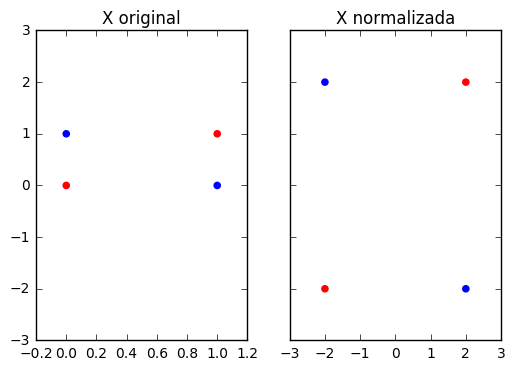

In [116]:
import numpy as np
import matplotlib.pyplot as plt

X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
Y = np.array([[0, 1, 1, 0]])

X_norm = normalize_input(X)

color= ['blue' if y == 1 else 'red' for y in np.squeeze(Y)]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.set_title("X original")
ax1.scatter(X[:,0], X[:,1], color=color)
ax2.set_title("X normalizada")
ax2.scatter(X_norm[:,0], X_norm[:,1], color=color)

plt.show()

X = X_norm.T

<hr>
# 2. Inicializacion de parametros de la red.

Utilizar unos valores de inicializacion de los pesos de la red $W^{[l]}$, muy bajos o muy altos, puede conducir al problema de la desvanecimiento o explosion de los gradientes, respectivamente. Es por ello que se hace necesario inicializar los pesos con un valor adecuado.

Segun analizamos en la clase anterior, existen aproximaciones formales para ello. Algunas formas son:

### <center>$W^{[l]} = np.random.randn(W^{[l]}.shape) * \sqrt{\frac{1}{n^{[l-1]}}}$</center>

### <center>$W^{[l]} = np.random.randn(W^{[l]}.shape) * \sqrt{\frac{2}{n^{[l-1]}}}$</center>

Xavier's Initialization:
### <center>$W^{[l]} = np.random.randn(W^{[l]}.shape) * \sqrt{ \frac{2}{n^{[l-1]} +n^{[l]} } }$</center>

In [117]:
#Xavier's Initialization
def initialize_parameters(neurons_hidden_layer):

    len_X = 2
    
    W1 = np.random.randn(neurons_hidden_layer, len_X) * np.sqrt(2./float(len_X + neurons_hidden_layer))
    b1 = np.zeros([neurons_hidden_layer,1])

    W2 = np.random.randn(1,neurons_hidden_layer) * np.sqrt(2./float(neurons_hidden_layer+1))
    b2 = np.zeros([1,1])
    
    parameters = {"W1":W1, "b1":b1, "W2":W2, "b2":b2}
    
    return parameters

In [118]:
params = initialize_parameters(2)
print(params)

{'b2': array([[ 0.]]), 'b1': array([[ 0.],
       [ 0.]]), 'W1': array([[ 1.11461169,  0.3551997 ],
       [-0.60971484,  0.11360462]]), 'W2': array([[-0.77783135,  1.31335284]])}


<hr>
# 3. Regularization

Esta tecnica permite reducir el problema de la alta varianza (High Variance), entendido como una alta diferencia entre el error medido sobre el dataset de entrenamiento (TRAIN SET) y de prueba (DEV SET). Por otra parte, permite reducir el sobreentrenamiento de la red neuronal, es decir, permite entrenas redes que encuentren soluciones mas generales.

En terminos de implementacion, la regularizacion L1 implica agregar un nuevo termino al gradiente de los pesos:

### <center>$dW^{[l]} = dW^{[l]} + \frac{\lambda}{m}W^{[l]}$</center>

Donde $\lambda$ se conoce como el termino de regularizacion y $m$ se refiere al numero de ejemplos del dataset.

In [121]:
'''
Metaparameters initialization
'''
num_epochs = 10000
learning_rate = 0.05
reg_param = 0.0001

'''
Parameters initialization
'''
parameters = initialize_parameters(3)
W1 = parameters["W1"]
b1 = parameters["b1"]
W2 = parameters["W2"]
b2 = parameters["b2"]

print ("parametros iniciales: ", parameters)

'''
Gradient descent
'''
for i in range(num_epochs):
    '''
    Forward Propagation
    '''
    Z1 = linear_activation(W1, b1, X)
    A1 = sigmoid(Z1)
    
    Z2 = linear_activation(W2, b2, A1)
    A2 = sigmoid(Z2)
        
    '''
    Backward Propagation
    '''
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T)
    db2 = np.mean(np.sum(dZ2, axis=1, keepdims=True))
    
    dZ1 = np.multiply(np.dot(W2.T, dZ2), d_sigmoid(Z1))
    dW1 = np.dot(dZ1, X.T)
    db1 = np.mean(np.sum(dZ1, axis=1, keepdims=True))
    
    '''
    Regularization
    '''
    dW1 = dW1 + reg_param * W1
    dW2 = dW2 + reg_param * W2
    
    '''
    Parameters Update
    '''
    W1 -= learning_rate * dW1
    W2 -= learning_rate * dW2
    b1 -= learning_rate * db1
    b2 -= learning_rate * db2
    
    '''
    Cost estimation
    '''
    J = cost(loss(Y,A2))
    
    
    if(i%1000 == 0):
        print("costo -- iteracion ", i, ": ", J)
        
print("parametros actualizados: ", parameters)

'''
Testing
'''
print("Predicciones del clasificador: ", predict_multilayer(parameters,X))

('parametros iniciales: ', {'b2': array([[ 0.]]), 'b1': array([[ 0.],
       [ 0.],
       [ 0.]]), 'W1': array([[-0.60535321, -0.85281842],
       [-0.25396729, -0.29629027],
       [ 0.32434625, -0.20638192]]), 'W2': array([[ 0.42617867, -0.42048088, -0.1809894 ]])})
('costo -- iteracion ', 0, ': ', 0.69468858363989083)
('costo -- iteracion ', 1000, ': ', 0.14048703663391704)
('costo -- iteracion ', 2000, ': ', 0.045538423243033102)
('costo -- iteracion ', 3000, ': ', 0.026972221278810174)
('costo -- iteracion ', 4000, ': ', 0.019206643849652604)
('costo -- iteracion ', 5000, ': ', 0.014962914837023075)
('costo -- iteracion ', 6000, ': ', 0.012294992888694499)
('costo -- iteracion ', 7000, ': ', 0.01046565809953221)
('costo -- iteracion ', 8000, ': ', 0.0091348661386650119)
('costo -- iteracion ', 9000, ': ', 0.0081242598346237711)
('parametros actualizados: ', {'b2': array([[ 6.41858829]]), 'b1': array([[ 4.15368838],
       [ 4.15368838],
       [ 4.15368838]]), 'W1': array([[-1.64

### - Visualizacion del resultado

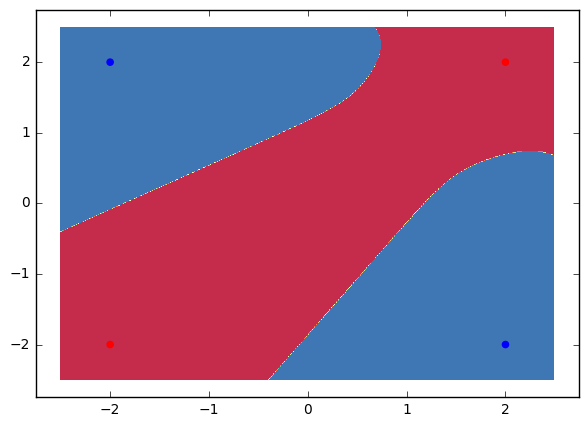

In [122]:
visualize_lr(parameters, X, Y)

<hr>
# Caso 2: Dataset generado

In [74]:
def tanh(z):
    return (np.exp(z)- np.exp(-z))/(np.exp(z)+ np.exp(-z))

In [75]:
def d_tanh(z):
    return 1. - tanh(z)**2

In [106]:
def predict_multilayer(parameters,X):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
        
    Z1 = linear_activation(W1, b1, X)
    A1 = tanh(Z1)
    
    Z2 = linear_activation(W2, b2, A1)
    A2 = sigmoid(Z2)

    return np.round(A2)

In [107]:
from utils import generate_data

X, Y = generate_data('moons')
X = normalize_input(X)

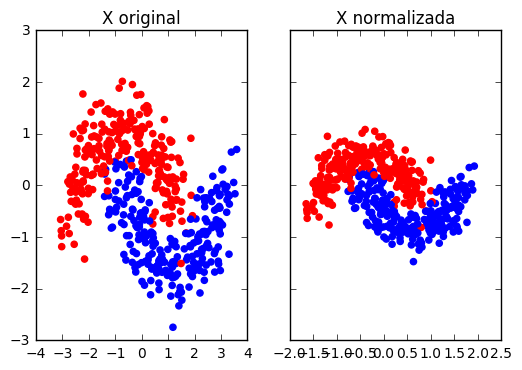

In [108]:
X_norm = normalize_input(X)

color= ['blue' if y == 1 else 'red' for y in np.squeeze(Y)]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.set_title("X original")
ax1.scatter(X[:,0], X[:,1], color=color)
ax2.set_title("X normalizada")
ax2.scatter(X_norm[:,0], X_norm[:,1], color=color)

plt.show()

X = X_norm.T

In [111]:
'''
Metaparameters initialization
'''
num_epochs = 20000
learning_rate = 0.001
reg_param = 0.01

'''
Parameters initialization
'''
parameters = initialize_parameters(3)
W1 = parameters["W1"]
b1 = parameters["b1"]
W2 = parameters["W2"]
b2 = parameters["b2"]

print ("parametros iniciales: ", parameters)

'''
Gradient descent
'''
for i in range(num_epochs):
    '''
    Forward Propagation
    '''
    Z1 = linear_activation(W1, b1, X)
    A1 = tanh(Z1)
    
    Z2 = linear_activation(W2, b2, A1)
    A2 = sigmoid(Z2)
        
    '''
    Backward Propagation
    '''
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T)
    db2 = np.mean(np.sum(dZ2, axis=1, keepdims=True))
    
    dZ1 = np.multiply(np.dot(W2.T, dZ2), d_tanh(Z1))
    dW1 = np.dot(dZ1, X.T)
    db1 = np.mean(np.sum(dZ1, axis=1, keepdims=True))
    
    '''
    Regularization
    '''
    dW1 = dW1 + reg_param * W1
    dW2 = dW2 + reg_param * W2
        
    '''
    Parameters Update
    '''
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    '''
    Cost estimation
    '''
    J = cost(loss(Y,A2))
    
    
    if(i%1000 == 0):
        print("costo -- iteracion ", i, ": ", J)
        
print("parametros actualizados: ", parameters)

'''
Testing
'''
print("Predicciones del clasificador: ", predict_multilayer(parameters,X))

('parametros iniciales: ', {'b2': array([[ 0.]]), 'b1': array([[ 0.],
       [ 0.],
       [ 0.]]), 'W1': array([[ 0.88883115,  1.02334737],
       [-0.52140211,  0.26726329],
       [ 0.34625712, -0.51468882]]), 'W2': array([[-1.02468089, -0.93176687,  0.38255058]])})
('costo -- iteracion ', 0, ': ', 0.53237157638969212)
('costo -- iteracion ', 1000, ': ', 0.123828293647104)
('costo -- iteracion ', 2000, ': ', 0.10154733916410875)
('costo -- iteracion ', 3000, ': ', 0.095323392927331149)
('costo -- iteracion ', 4000, ': ', 0.092676127765383337)
('costo -- iteracion ', 5000, ': ', 0.091321461612012461)
('costo -- iteracion ', 6000, ': ', 0.09053871607026287)
('costo -- iteracion ', 7000, ': ', 0.090039588959372543)
('costo -- iteracion ', 8000, ': ', 0.089691070126111105)
('costo -- iteracion ', 9000, ': ', 0.089425279969770316)
('costo -- iteracion ', 10000, ': ', 0.089204542663394629)
('costo -- iteracion ', 11000, ': ', 0.089006085214283298)
('costo -- iteracion ', 12000, ': ', 0.08

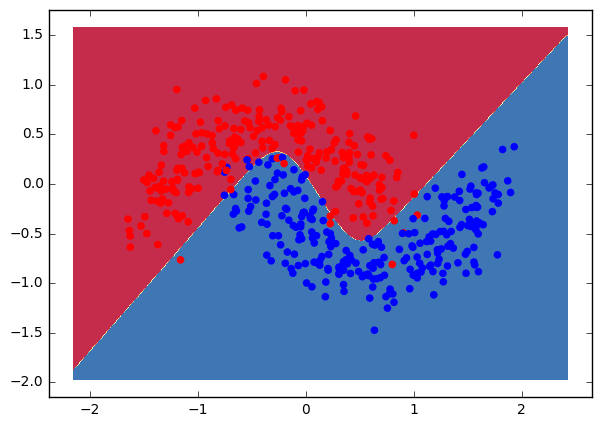

In [112]:
visualize_lr(parameters, X, Y)